# MOwNiT
## Laboratorium 2 - Arytmetyka komputerowa


Kalkulatory IEEE-754:
* https://www.h-schmidt.net/FloatConverter/IEEE754.html

Więcej o arytmetyce zmiennoprzecinkowej w pythonie:
* https://docs.python.org/3/tutorial/floatingpoint.html

W pythonie nie mamy żadnej gotowej funkcji do otrzymania reprezentacji binarnej typu `float`, tylko dla typu `int`. Mamy jednak w bibliotece `numpy` metodę `view`, która znajduje kodowanie `numpy.intXX` zmiennej typu `numpy.floatXX`.

Poza tym, również w `numpy`, mamy funkcję `numpy.binary_repr`, która znajduje reprezentację binarną określonej długości dla zmiennej typu `numpy.intXX`.

**Ważne** żeby faktycznie zobaczyć reprezentację binarną zmiennnej typu `numpy.floatXX`, musimy zapewnić `width=XX`. Nie da się tego zrobić wbudowaną funkcją `bin()`.

In [1]:
import numpy as np

x_float=-2.5
x_bin=np.binary_repr(np.float32(x_float).view(np.int32),width=32)

print(x_bin)

11000000001000000000000000000000


Pierwsze `1` informuje o znaku `-`. Wykładnik to `10000000` a mantysa to `01000000000000000000000`.

In [2]:
def float32_to_bin(x):
    x_bin=str(np.binary_repr(np.float32(x).view(np.int32),width=32))
    sgn=x_bin[0]
    exp=x_bin[1:9]
    man=x_bin[9:]
    print(f'sgn={sgn} exp={exp} mantissa={man}')
    return int(sgn,2),int(exp,2),int(man,2)

In [3]:
float32_to_bin(-2.5)

sgn=1 exp=10000000 mantissa=01000000000000000000000


(1, 128, 2097152)

## Trochę teorii o IEEE-754

Liczby zmienno przecinkowe są zapisywane w standardzie jako:

$L = (-1)^{znak} * mantysa * 2^{cecha}$ 

* znak - 0 oznacza liczbę dodatnią, 1 ujemną
* mantysa - wpływa na precyzje
* cecha - wpływa na zakres, składająca się z samych 0 albo 1 ma specjalne znaczenie

| Nazwa     | Liczba bitów | Bity znaku | Bity cechy | Bity mantysy | Bias  | Dokładność (cyfry znaczące) | Uwagi                                 |
|-----------|--------------|------------|------------|--------------|-------|-----------------------------|---------------------------------------|
| half      | 16           | 1          | 5          | 10           | 15    | 4                           |                                       |
| single    | 32           | 1          | 8          | 23           | 127   | 7                           |                                       |
| double    | 64           | 1          | 11         | 52           | 1023  | 16                          |                                       |
| quadruple | 128          | 1          | 15         | 112          | 16383 | 34                          | Wprowadzone w 2008, niezbyt popularne |

### Liczby znormalizowane

Mantysa ma wartość z przedziału [1,2) - pierwszy bit ma zawsze wartość 1, więc nie trzeba go zapisywać (jest on tam "domyślnie")
$L = (-1)^{znak} * 1.mantysa * 2^{cecha-bias}$

In [39]:
float32_to_bin(2.5)

sgn=0 exp=10000000 mantissa=01000000000000000000000


(0, 128, 2097152)

Policzenie wartości na podstawie reprezentacji bitowej.

In [4]:
cecha = 2**7-127
mantysa = 2**(-2) + 1
cecha, mantysa

(1, 1.25)

In [5]:
L = 1 * mantysa * 2**(cecha)
L

2.5

### Liczba 0

Wartości 0 nie da się zapisać w postaci znormalizowanej. Jeżeli zarówno mantysa jak i cecha zawierają same 0, to reprezentowana jest wartość 0.

Ze względu na bit znaku teoretycznie istnieją dwie możliwości 0: +0 oraz -0.

In [6]:
float32_to_bin(0.0)

sgn=0 exp=00000000 mantissa=00000000000000000000000


(0, 0, 0)

In [7]:
float32_to_bin(-0.0)

sgn=1 exp=00000000 mantissa=00000000000000000000000


(1, 0, 0)

In [8]:
np.float32(-0.0) == np.float32(+0.0) # Oba zera są równe

True

### Liczby zdenormalizowane

Jeżeli cecha składa się z samych 0 to liczba jest *zdenormalizowana* i mantysa nie posiada "domyślnego" bitu. Pozwala to na reprezentacje liczb bliskich 0, które bez denormalizacji byłyby 0.

$L = (-1)^{znak} * 0.mantysa * 2^{-bias+1}$

Uwaga: Liczba 0 nie jest określana jako zdenormalizowana, pomimo, że cecha ma same 0!

In [9]:
L = np.float32(1e-42)
float32_to_bin(L)

sgn=0 exp=00000000 mantissa=00000000000001011001010


(0, 0, 714)

### Wartości specjalne

####  Nieskończoność

Reprezentowana jest przez cechę z samych 1 oraz mantysę z samych 0. W zależności od znaku można wyróżnić $-\infty$ oraz $+\infty$.

In [10]:
float32_to_bin(np.inf)

sgn=0 exp=11111111 mantissa=00000000000000000000000


(0, 255, 0)

In [60]:
float32_to_bin(-np.inf)

sgn=1 exp=11111111 mantissa=00000000000000000000000


(1, 255, 0)

#### NaN

Reprezentowana jest przez cechę z samych 1 oraz mantysę różną od 0.

`NaN`ami są np. 0/0, $\infty - \infty$

In [11]:
np.float32(0)/np.float32(0)

/tmp/ipykernel_6111/1976941368.py:1: RuntimeWarning: invalid value encountered in scalar divide
  np.float32(0)/np.float32(0)


nan

In [12]:
np.inf-np.inf

nan

In [13]:
float32_to_bin(np.nan)

sgn=0 exp=11111111 mantissa=10000000000000000000000


(0, 255, 4194304)

### Praktyczne wskazówki

Kolejność działań ma znaczenie:

In [14]:
e = np.float64(1e-16)
e

1e-16

In [15]:
(np.float32(1.0) + e) + e

1.0

In [16]:
np.float32(1.0) + (e + e)

1.0000000000000002

Wniosek: Sumujemy od najmniejszych

Nie powinno się porównywać floatów bezpośrednio. Większość języków posiada funkcje do porówywania liczb zmiennoprzecinkowych z tolerancją, np. `isapprox` w Julii, `numpy.isclose` w Pythonie etc.

In [17]:
0.1 + 0.2 == 0.3

False

In [18]:
np.isclose(0.1 + 0.2, 0.3)

True

## Przykłady

In [19]:
np.binary_repr(np.float16(0.1).view(np.int16),width=16)

'0010111001100110'

In [20]:
np.binary_repr(np.float32(0.1).view(np.int32),width=32)

'00111101110011001100110011001101'

In [21]:
np.binary_repr(np.float64(0.1).view(np.int64),width=64)

'0011111110111001100110011001100110011001100110011001100110011010'

In [22]:
# co ile liczby sa reprezentowane
for i in range(10):
    print(np.binary_repr(np.float32(np.nextafter(i,11)).view(np.int32),width=32))
    

00000000000000000000000000000000
00111111100000000000000000000000
01000000000000000000000000000000
01000000010000000000000000000000
01000000100000000000000000000000
01000000101000000000000000000000
01000000110000000000000000000000
01000000111000000000000000000000
01000001000000000000000000000000
01000001000100000000000000000000


In [23]:
# Maszynowe epsilon mówi, jaki jest odstęp między kolejnymi liczbami zmiennoprzecinkowymi reprezentowanymi w komputerze
np.finfo(np.float32).eps

1.1920929e-07

In [24]:
np.finfo(np.float64).eps

2.220446049250313e-16

In [25]:
# Badanie postaci zdenormalizowanej. Co się dzieje, jak liczby są coraz mniejsze?
a = np.float32(1e-33)
while a > 0:
    a = a/np.float32(2.0)
    print(a)
    float32_to_bin(a)


5e-34
sgn=0 exp=00010000 mantissa=01001100010011101001100
2.5e-34
sgn=0 exp=00001111 mantissa=01001100010011101001100
1.25e-34
sgn=0 exp=00001110 mantissa=01001100010011101001100
6.25e-35
sgn=0 exp=00001101 mantissa=01001100010011101001100
3.125e-35
sgn=0 exp=00001100 mantissa=01001100010011101001100
1.5625e-35
sgn=0 exp=00001011 mantissa=01001100010011101001100
7.8125e-36
sgn=0 exp=00001010 mantissa=01001100010011101001100
3.90625e-36
sgn=0 exp=00001001 mantissa=01001100010011101001100
1.953125e-36
sgn=0 exp=00001000 mantissa=01001100010011101001100
9.765625e-37
sgn=0 exp=00000111 mantissa=01001100010011101001100
4.8828126e-37
sgn=0 exp=00000110 mantissa=01001100010011101001100
2.4414063e-37
sgn=0 exp=00000101 mantissa=01001100010011101001100
1.2207032e-37
sgn=0 exp=00000100 mantissa=01001100010011101001100
6.103516e-38
sgn=0 exp=00000011 mantissa=01001100010011101001100
3.051758e-38
sgn=0 exp=00000010 mantissa=01001100010011101001100
1.525879e-38
sgn=0 exp=00000001 mantissa=010011000

In [26]:
#Rysowanie wykresów scatterplot

import matplotlib.pyplot as plt

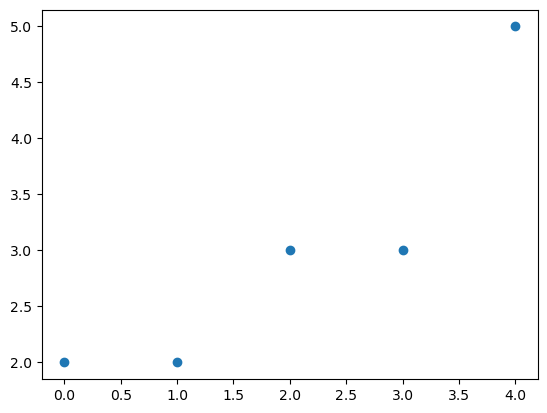

In [27]:
plt.scatter(range(5), [2,2,3,3,5])

## Bonus

Ciekawe zastosowanie znajomości IEEE-754 do obliczania odwrotności pierwiastka, wykorzystane w grze Quake 3: [filmik](https://youtu.be/p8u_k2LIZyo)

# Zadania

### Zadanie 1

Porównać w języku python reprezentację bitową liczby 1/3 dla `np.float16`, `np.float32`, `np.float64` oraz liczby, 
która jest inicjalizowana jako `np.float16`, a potem rzutowana na `np.float64`.

### Zadanie 2

Zbadać, jak zmienia się odległość między kolejnymi liczbami zmiennoprzecinkowymi 
reprezentowanymi w komputerze za pomocą języka python. 
Narysować wykres używając `matplotlib.pyplot` zależności odległości od wartości liczby dla zakresu  od 1.0 do 1000000.0.

### Zadanie 3

Jedną z bibliotek numerycznych, jaką dodatkowo będziemy używać na zajęciach jest <a href="http://www.gnu.org/software/gsl/gsl.html">GSL</a> (język C). Opis <a href="https://www.gnu.org/software/gsl/doc/html/usage.html"> jak używać </a>. Korzystając ze <a href="https://www.gnu.org/software/gsl/doc/html/ieee754.html"> wsparcia dla wyświetlania reprezentacji liczb zmiennoprzecinkowych</a> zobaczyć jak zmienia się cecha i mantysa dla coraz mniejszych liczb. Zaobserwować, kiedy matysa przestaje być znormalizowana i dlaczego?

Kod załączyć jako komórka Markdown sformatowana jako C ([link](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#code)). Wynik także jako Markdown (kod albo fragment zrzutu ekranu).

### Zadanie 4

Na przykładzie wybranego algorytmu niestabilnego numerycznie: 
1. Pokazać, że działa źle.
2. Pokazać które konkretnie działania powodują zwiększenie błędu (np. dzielenie przez małą liczbę, cancellation).
3. Zademonstować wersję stabilną.

Wszystkie punkty przedstawić w postaci notatnika Jupytera w pythonie.